[View in Colaboratory](https://colab.research.google.com/github/sergeivolodin/ProbabilisticNeuronFailureCode/blob/master/DropoutErrorVarianceKerasColab.ipynb)

In [0]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.core import Lambda
from keras.optimizers import SGD
from keras.initializers import Constant
from keras import backend as K
from keras.utils import plot_model
from functools import partial
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline
from matplotlib import pyplot as plt

In [0]:
def PermanentDropout(p_fail):
  """ Make dropout work using predict() """
  return Lambda(lambda x: K.dropout(x, level=p_fail))
  
def create_model(p_fails, layer_weights, layer_biases, KLips):
  """ Create some simple network """
  assert(len(p_fails) == len(layer_weights))
  assert(len(layer_biases) == len(layer_weights))
  
  model = Sequential()
  for i, (p_fail, w, b) in enumerate(zip(p_fails, layer_weights, layer_biases)):
    is_last = i + 1 == len(p_fails)
    model.add(Dense(w.shape[1], input_shape = (w.shape[0], ),
                    kernel_initializer = Constant(w),
                    activation = 'linear' if is_last else get_custom_activation(KLips),
                    bias_initializer = Constant(b)))
    if not is_last and p_fail > 0:
      model.add(PermanentDropout(p_fail))
  
  model.compile(loss='binary_crossentropy', optimizer = 'sgd')
  #model.summary()
  return model

norm1 = partial(np.linalg.norm, ord = 1)
norm2 = partial(np.linalg.norm, ord = 2)
def dot_abs(x, y):
  return np.dot(np.abs(x), np.abs(y))
def norm1_minus_dot_abs(x, y):
  return norm1(x) * norm2(y) - dot_abs(x, y)

def get_custom_activation(KLips):
  def custom_activation(x):
    return K.sigmoid(4 * KLips * x)
  return custom_activation

class Experiment():
  def __init__(self, N, P, KLips):
    assert(len(N) == len(P) + 1)
    self.N = N + [1]
    self.P = P + [0]
    self.model = None
    self.C = 1.
    self.K = KLips
    self.init_weights()
  def init_weights(self):
    self.W = []
    self.B = []
    for i in range(1, len(self.N)):
      w = np.random.randn(self.N[i - 1], self.N[i]) / (self.N[i - 1])
      b = np.random.randn(self.N[i]) / self.N[i]
      self.W.append(w)
      self.B.append(b)
    self.model = create_model(self.P, self.W, self.B, self.K)
    self.model_no_dropout = create_model([0] * len(self.P), self.W, self.B, self.K)
  def predict_no_dropout(self, data):
    return self.model_no_dropout.predict(np.array([data]))[0][0]
  def predict(self, data, repetitions = 100):
    data = np.repeat(np.array([data]), repetitions, axis = 0)
    return self.model.predict(data).T[0]
  def plot_error(experiment, inp, repetitions = 100):
    results = experiment.predict(inp, repetitions = repetitions)
    true = experiment.predict_no_dropout(inp)
    plt.title('Network error P=' + ', '.join([str(v) for v in experiment.P[:-1]]) +
              ' N=' + ', '.join([str(v) for v in experiment.N[:-1]]))
    plt.xlabel('Network output')
    plt.ylabel('Frequency')
    plt.hist(results, density = True)
    plt.plot([true, true], [0, 1], label = 'True value')
    plt.legend()
    plt.show()
    return results - true
  def get_error(experiment, inp, repetitions = 100):
    return experiment.predict(inp, repetitions = repetitions) - experiment.predict_no_dropout(inp)
  def get_wb(self, layer):
    return np.vstack((self.W[layer], self.B[layer]))
  def get_max_f(self, layer, func):
    wb = self.get_wb(layer)
    res = [func(w_neuron) for w_neuron in wb.T]
    return np.max(res)
  def get_max_f_xy(self, layer, func):
    wb = self.get_wb(layer)
    res = [func(w_neuron1, w_neuron2) for w_neuron1 in wb.T for w_neuron2 in wb.T]
    return np.max(res)
  def get_mean_std_error(self):
    EDelta = 0.
    EDelta2 = 0.
    EDeltaArr = [0]
    EDelta2Arr = [0]
    for layer in range(len(self.W)):
      p_l = self.P[layer]
      w_1_norm = self.get_max_f(layer, norm1)
      alpha = self.get_max_f_xy(layer, dot_abs)
      beta = self.get_max_f_xy(layer, norm1_minus_dot_abs)
      a = self.C ** 2 * p_l * (alpha + p_l * beta) + 2 * self.K * self.C * p_l * (1 - p_l) * beta * EDelta
      b = self.K ** 2 * (1 - p_l) * (alpha + (1 - p_l) * beta)
      EDelta2 = a + b * EDelta2
      EDelta = p_l * w_1_norm * self.C + self.K * w_1_norm * (1 - p_l) * EDelta
      EDeltaArr.append(EDelta)
      EDelta2Arr.append(EDelta2)
    print(EDeltaArr, EDelta2Arr)
    return EDelta, EDelta2 ** 0.5

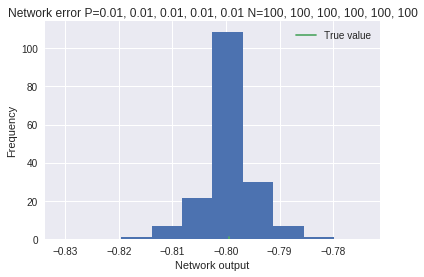

AbsMean 0.003017 Std 0.004711
[0, 0.009305290435565989, 0.00976995247649731, 0.00988653252681622, 0.010417382377298863, 0.009563955882414056, 1.4469034068154024e-05] [0, 0.00014626876525120278, 0.00014836631893919922, 0.00015155232348125462, 0.00017107816102004318, 0.00015348656072871358, 1.7946113377105907e-10]
Equation AbsMean 0.000014 Std 0.000013


In [106]:
experiment = Experiment([100, 100, 100, 100, 100, 100], [0.01, 0.01, 0.01, 0.01, 0.01], 0.001)
error = experiment.plot_error(np.ones(100), repetitions = 10000)
print('AbsMean %f Std %f' % (np.mean(np.abs(error)), np.std(error)))
print('Equation AbsMean %f Std %f' % experiment.get_mean_std_error())